# Machine Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of several Machine Learning techniques in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations. The Machine Learning techniques which were evaluated are:

- Ridge Regression;
- K-Nearest Neighbors (KNN);
- Random Forest (RF);
- Support Vector Regression (SVR);
- Extreme Gradient Boosting (XGBoost);

### Importing the Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures as Poly
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test, Method,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(10,300)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(140, 180, '$+ 10 \%$', fontsize=12)
        plt.text(150, 120, '$- 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - ' + Method )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - '+Method +'.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(23, 17, '$- 10 \%$', fontsize=12)
        plt.text(19, 28, '$+ 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - ' + Method )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - '+Method +'.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

The Dataset is divided into Training (80%) and Test (20%) sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Training Function

The models are trained by a Grid Search cross validation technique. 

In [5]:
def ML_Model(X_train,y_train,X_test,y_test,Algo,Obj):
    
    # Ridge Regression
    if Algo == 'Ridge':
        param = {'ridge__alpha': [0,0.001,0.005,0.01,0.05,0.1,0.5,1],
                 'polynomialfeatures__degree' :[1,2,3,4],
                 'polynomialfeatures__include_bias': [True, False],
                 'polynomialfeatures__interaction_only': [True, False]
                 
                }
        model = make_pipeline(Poly(),
                              Ridge())
   
    # K-Nearest Neighbors
    elif Algo == 'KNN':
        param = {'n_neighbors': [1,5,10,20,50,100],
                 'leaf_size': [1,5,10,20,50,100],
                 'p': [1,3,5],
                 'weights': ('uniform', 'distance'),
                }
        model = KNeighborsRegressor()
    
    # Ranfom Forest
    elif Algo == 'RF':
        param = {'n_estimators': [5,25,50,100],
                 'max_features': ['auto', 'sqrt'],
                 'max_depth': [5,10,50],
                 'min_samples_split': [2,6,10],
                 'min_samples_leaf' : [1,3,5]
                }
        model = RandomForestRegressor()
    
    #Support Vector Regression
    elif Algo =='SVR':
        param = {'kernel':['linear','rbf', 'poly', 'sigmoid'],
                 #'C':[0.1,1, 10, 100],
                 #'gamma': [1,0.1,0.01,0.001]
                 #'epsilon':[0.1, 0.2]
                  }
        model = SVR()
    
    #XGBoost 
    elif Algo == 'XGBoost':
        param = {'objective':['reg:squarederror'],
                 'learning_rate': [0.01, 0.02],
                 'max_depth': [5, 6, 7],
                 'min_child_weight': [1,3],
                 'alpha' :[1,5],
                 'gamma': [1,2],
                 'subsample': [0.5, 0.75],
                 'colsample_bytree': [0.75,1],
                 'n_estimators': [500, 1000]
                }
        model = XGBRegressor()
    
    #GridSearch Cross Validation
    model = GridSearchCV(model,
                         param_grid=param,
                         scoring = 'r2',
                         verbose = 2
                        )
    
    #Training the Model
    model.fit(X_train, y_train[Obj])
    print(model.best_params_)

    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using '+ Algo +' is '+
          str(r2_score(y_train[Obj],model.predict(X_train).T)))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using '+ Algo +' is '+
          str(r2_score(y_test[Obj], model.predict(X_test).T))) 

    # Plotting the Results
    plot_results(y_train[Obj], model.predict(X_train).T, y_test[Obj],model.predict(X_test).T, Algo, Obj) 
  
    # Saving the Model
    joblib.dump(model, 'Models/'+Obj+'/'+Obj+' - '+Algo+'.pkl')
    
    #Returning the Train and Test Sets R2
    return r2_score(y_train[Obj],model.predict(X_train).T),r2_score(y_test[Obj], model.predict(X_test).T)

### Evaluation of the Techniques

In [6]:
#List of Algorithms being Evaluated
#Algo = ['Ridge1','Ridge2','Ridge3','Ridge4','KNN','RF','SVR','XGBoost']
Algo = ['Ridge','KNN','RF','SVR','XGBoost']

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.

[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1,

[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialf

[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.1s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, p

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.44551e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.26196e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.5173e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.29612e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3596e-17): result may not be accurate.


[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=2, 

[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynom

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.37589e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.92724e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08198e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.86578e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.20802e-17): result may not be accurate

[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures_

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.22472e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.12876e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.23191e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21553e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21165e-19): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, p

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.98044e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.86606e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.99299e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94218e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87482e-18): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfea

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.50027e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.36151e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.57967e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.34776e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.29448e-23): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.66078e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.0768e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.1s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24059e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.45353e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.0058e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.1s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.35991e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53977e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.49905e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.76984e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, p

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47831e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.60253e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.16421e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.75485e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.32445e-21): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.02511e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.27053e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.52909e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.43943e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.55404e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45742e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.51456e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.08739e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.94291e-20): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures_

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.95063e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.05997e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.35909e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33586e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.3133e-21): result may not be accurate.

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3,

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.23191e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21553e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21165e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.14386e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08672e-18): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3,

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.86606e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.99299e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94218e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87482e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.74312e-18): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, po

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.69387e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54424e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.40085e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.76531e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.66317e-17): result may not be accurate


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.7239e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.70461e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.96851e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.19981e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.85245e-17): result may not be accurate.

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.81661e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.26164e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.32253e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.8929e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94097e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.20493e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.50027e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.36151e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.57967e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.34776e-23): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.67206e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.59571e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.80952e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.60496e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.66078e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.0768e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.24059e-22): result may not be accurate.

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.45353e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.0058e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.35991e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degre

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53977e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.49905e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.76984e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47831e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.60253e-21): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, 

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.75485e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.32445e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.02511e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.27053e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.52909e-20): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynom

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45742e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.51456e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.08739e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.94291e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.13612e-20): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.45257e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.57444e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7077e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79886e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79533e-23): result may not be accurate.

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, p

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.68356e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.98221e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.45947e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.94709e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.28783e-22): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynom

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.79098e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.76041e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.87911e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.8623e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.14337e-21): result may not be accurate.

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfea

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.49422e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43509e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43313e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.51727e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.96455e-20): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__i

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.03826e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.1361e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.22382e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47853e-27):

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4,

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.57444e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7077e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79886e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79533e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.05386e-22): result may not be accurate.

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.68356e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.98221e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.45947e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.94708e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.28783e-22): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, po

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.76041e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.87911e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.8623e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.14337e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09306e-21): result may not be accurate.

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomia

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43509e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43313e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.51727e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.96455e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.08977e-20): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.1s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.22411e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


{'polynomialfeatures__degree': 3, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False, 'ridge__alpha': 0.05}
The coefficient of determination for Qc Training Set using Ridge is 0.9988192913751832
The coefficient of determination for Qc Test Set using Ridge is 0.9980612581013804
Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0

[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=1, p

[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=1, polynomialf

[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, p

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.44551e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.26196e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.5173e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.29612e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3596e-17): result may not be accurate.


[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degre

[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynom

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.37589e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.92724e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08198e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.86578e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.20802e-17): result may not be accurate


[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=2, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.22472e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.12876e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.23191e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21553e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21165e-19): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polyn

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.99299e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94218e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87482e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.74312e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.2212e-18): result may not be accurate.


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfe

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.96851e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.19981e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.85245e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.61156e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.81661e-17): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.50027e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.36151e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.57967e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.34776e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.29448e-23): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degre

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.45353e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.0058e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.35991e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53977e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.49905e-21): result may not be accurate.

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, po

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.27053e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.52909e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.43943e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.55404e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45742e-20): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialf

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.3133e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.30643e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.18762e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.22472e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.12876e-19): result may not be accurate.


[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degr

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.99299e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94218e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87482e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.74312e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.2212e-18): result may not be accurate.

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, po

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.19981e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.85245e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.61156e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.81661e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.26164e-26): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeature

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.36151e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.57967e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.34776e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.29448e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.67206e-22): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures_

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.35991e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53977e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.49905e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.76984e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47831e-21): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=3,

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.55404e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45742e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.51456e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.08739e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.94291e-20): result may not be accurate

[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=3, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatu

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.45257e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.57444e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.7077e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79886e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79533e-23): result may not be accurate.

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.53428e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.97918e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.68356e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.98221e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.45947e-22): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynom

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.57595e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.61123e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.81742e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.79098e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.76041e-21): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialf

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.14337e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09306e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09321e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.2718e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.39775e-20): result may not be accurate.


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43509e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.43313e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.51727e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.96455e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.08977e-20): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=True, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__inc

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.03826e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.1361e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=True, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures_

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.05386e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.53428e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.97918e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.68356e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.98221e-22): result may not be accurate

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.14337e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09306e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09321e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.2718e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.39775e-20): result may not be accurate.

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=True, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynom

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.001; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.005; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__de

C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.01; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.05; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=0.5; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s


C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Guilh\anaconda3\lib\site-packages\sklearn\l

[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
[CV] END polynomialfeatures__degree=4, polynomialfeatures__include_bias=False, polynomialfeatures__interaction_only=False, ridge__alpha=1; total time=   0.0s
{'polynomialfeatures__degree': 3, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False, 'ridge__alpha': 0.05}
The coefficient of determination for Wm Training Set using Ridge is 0.9998263265356442
The coefficient of determination for Wm Test Set using Ridge is 0.9996204645617115
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END ...leaf_size=1, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=1, p=1, weights=uniform; tota

[CV] END ..leaf_size=1, n_neighbors=20, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=20, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=20, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=20, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=20, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=20, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=20, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=20, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=20, p=1, weights=distance; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=20, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=20, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=20, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_ne

[CV] END ..leaf_size=5, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=1, p=3, weights=distance; total time=   0.0s
[CV] END ...leaf_size=5, n_neighbors=1, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=5, n_neighbors=1, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=5, n_neighbors=1, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=5, n_neighbors=1, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=5, n_neighbors=1, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END ...leaf_size=5, n_n

[CV] END ..leaf_size=5, n_neighbors=50, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=50, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=50, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=50, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=50, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=50, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=50, p=1, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END .leaf_size=5, n_nei

[CV] END ..leaf_size=10, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_ne

[CV] END leaf_size=10, n_neighbors=100, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=100, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=10,

[CV] END leaf_size=20, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_nei

[CV] END ..leaf_size=50, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=50, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=50, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=50, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=50, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END ..leaf_size=50, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=50, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=50, n_n

[CV] END .leaf_size=50, n_neighbors=20, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=20, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_nei

[CV] END leaf_size=100, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=1, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=100, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=100, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=100, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=100, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=100, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_ne

[CV] END leaf_size=100, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100,

[CV] END ...leaf_size=1, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ...leaf_size=1, n_neighbors=5, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=1, n_ne

[CV] END .leaf_size=1, n_neighbors=100, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=100, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=1, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=1, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=1, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=1, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=1, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END .leaf_size=1, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=1, n_neig

[CV] END .leaf_size=5, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=5, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=5, n_nei

[CV] END leaf_size=5, n_neighbors=100, p=5, weights=distance; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END ..leaf_size=10, n_neighbors=1, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=10, n_n

[CV] END leaf_size=10, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=20, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=10, n_neighbors=20, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=20, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_neighbors=20, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=10, n_nei

[CV] END ..leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END ..leaf_size=20, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=20, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=20, n_neighbors=5, p=3, weights=uniform; total time=   0.0s
[CV] END ..leaf_size=20, n_n

[CV] END .leaf_size=20, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=50, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=20, n_neighbors=50, p=3, weights=distance; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END .leaf_size=20, n_neighbors=50, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=20, n_nei

[CV] END .leaf_size=50, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=5, p=5, weights=distance; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END .leaf_size=50, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=10, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=10, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_nei

[CV] END leaf_size=50, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=uniform; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50, n_neighbors=100, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=50

[CV] END leaf_size=100, n_neighbors=10, p=3, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=uniform; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=10, p=5, weights=distance; total time=   0.0s
[CV] END leaf_size=100, n_neighbors=20, p=1, weights=uniform; total time=   0.0s
[CV] END leaf_size=100

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.

[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=5, max_features=auto, min_samples_l

[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=25; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=25; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5,

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_

[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_sa

[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_sa

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, m

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=aut

[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.3s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_sa

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_sa

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.8s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, m

[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=25; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=25; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samp

[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samp

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_lea

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_l

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=25; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=50; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_lea

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=auto, mi

[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=sqr

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=25; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_sa

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min

[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_sa

[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=auto, m

[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=auto,

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, max_features=s

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_sa

[CV] END .....................................kernel=sigmoid; total time=   0.0s
[CV] END .....................................kernel=sigmoid; total time=   0.0s
[CV] END .....................................kernel=sigmoid; total time=   0.0s
{'kernel': 'linear'}
The coefficient of determination for Qc Training Set using SVR is 0.6230803066959301
The coefficient of determination for Qc Test Set using SVR is 0.5586362098759527
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................kernel=linear; total time=  19.2s
[CV] END ......................................kernel=linear; total time=  22.5s
[CV] END ......................................kernel=linear; total time=  28.2s
[CV] END ......................................kernel=linear; total time=  26.3s
[CV] END ......................................kernel=linear; total time=  19.4s
[CV] END .........................................kernel=rbf; total time=   0.0s
[CV] END ...............

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.9s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_dept

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, 

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   3.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_dept

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   2.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, 

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_dept

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   2.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.7s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weigh

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.2s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.8s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   6.3s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.2s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_w

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, 

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weigh

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   3.7s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.9s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.3s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_wei

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.0s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.2s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weigh

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.7s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   5.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.7s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   3.4s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_we

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_dept

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   5.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, 

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   2.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.2s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_dept

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, 

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   3.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.0s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_dept

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_c

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   4.2s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.3s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weigh

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   4.3s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.5s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.6s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.6s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3,

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weigh

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.7s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_we

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.6s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.7s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_we

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.6s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   2.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.6s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, 

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   2.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_dept

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   3.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, 

[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_dept

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, 

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=

[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.4s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.5s
[CV] END alpha=1, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_dept

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weig

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weigh

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_

[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1,

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.1s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weigh

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.3s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_we

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.4s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weigh

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.4s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.4s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weig

[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.3s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.6s
[CV] END alpha=1, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.2s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=5, min_c

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=6, 

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.01, max_depth=

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_dept

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   2.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.1s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth

[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.75, gamma=1, learning_rate=0.02, max_depth=7, 

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.0s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   1.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_dept

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=6, 

[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.5s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=0.75, gamma=2, learning_rate=0.02, max_depth=

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=5, min_child_wei

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=6, min_child_weight

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=7, min_child_weight

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.7s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=5, min_child_weigh

[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=1, learning_rate=0.02, max_depth=7, min_child_we

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=5, min_child_weight=1

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=6, min_child_weigh

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.01, max_depth=7, min_child_w

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=5, min_child_weight=3, 

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.75; total time=   0.4s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=6, min_child_weigh

[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.8s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.5; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   0.9s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_weight=3, n_estimators=1000, objective=reg:squarederror, subsample=0.75; total time=   1.0s
[CV] END alpha=5, colsample_bytree=1, gamma=2, learning_rate=0.02, max_depth=7, min_child_wei

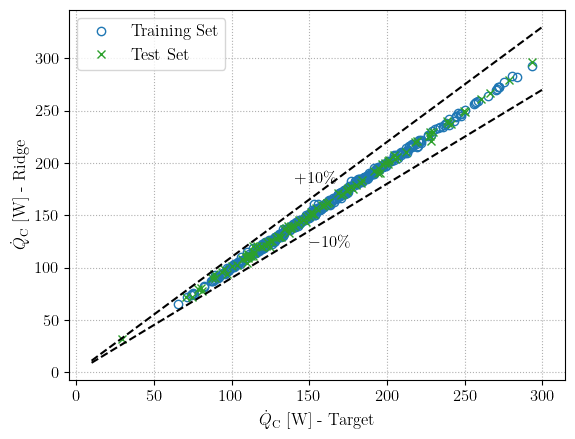

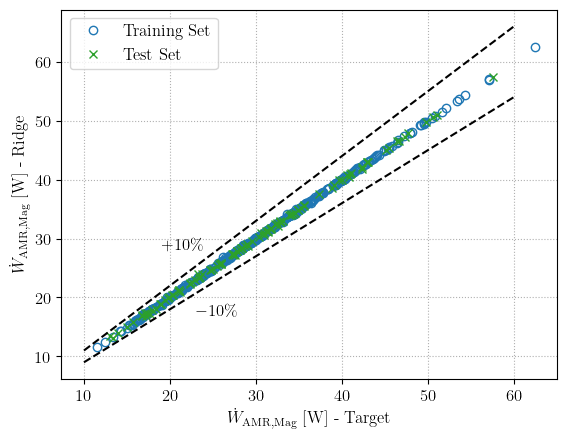

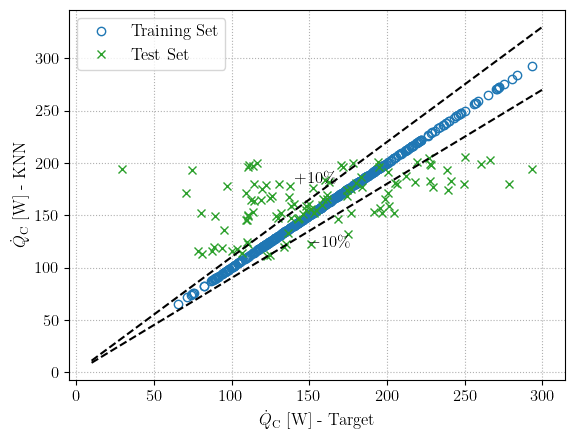

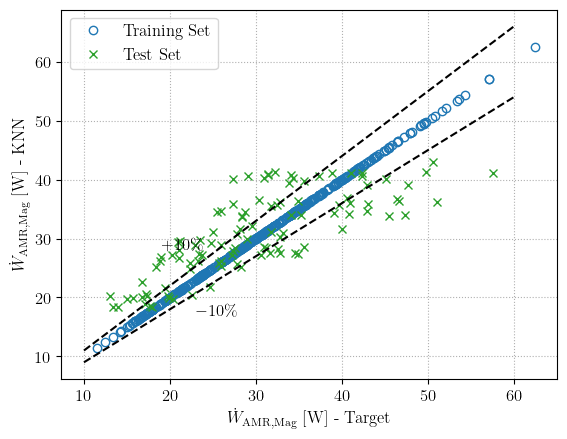

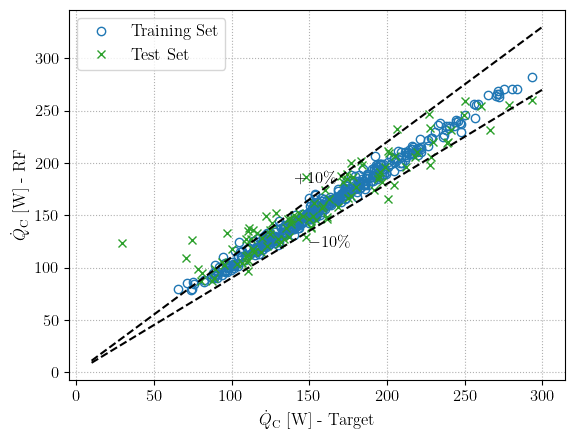

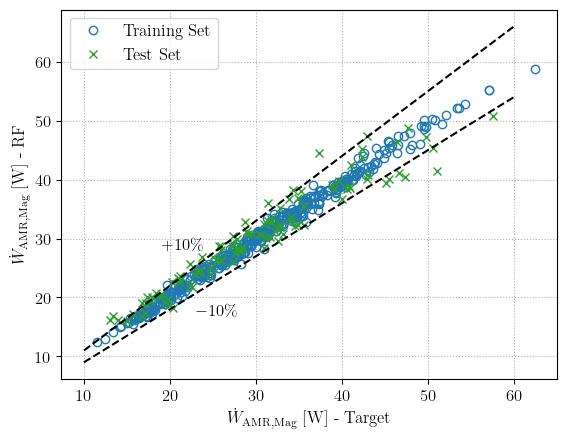

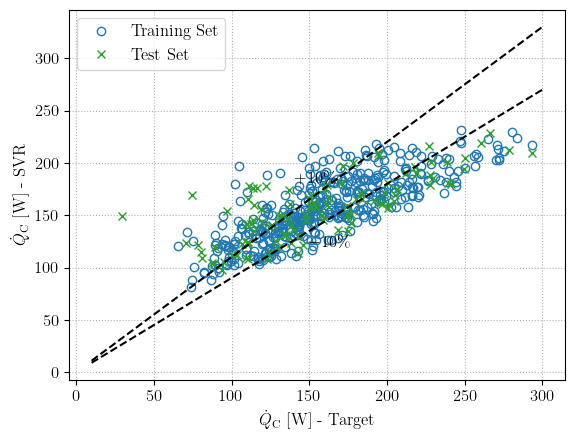

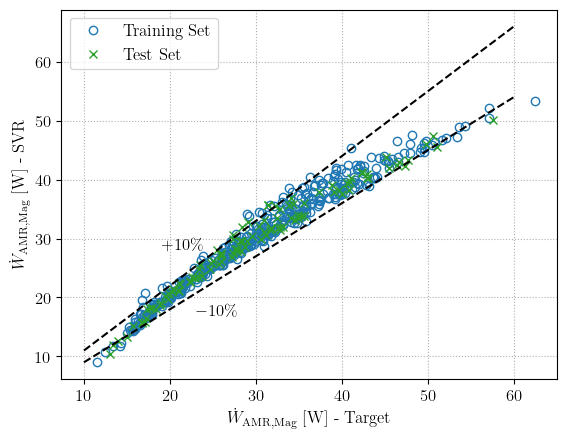

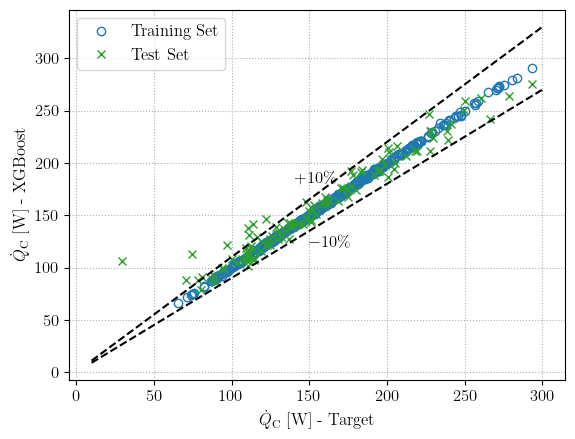

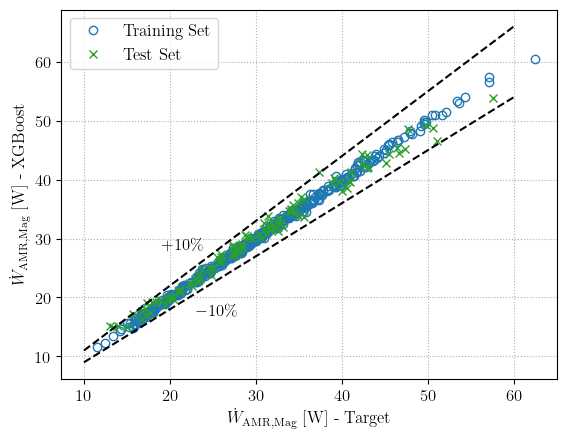

In [7]:
# Lists for saving the R2 Coefficients
R2_Qc = []
R2_Wm = []

#Running the ML_Model functions for each Algorithm and Objective
for i in Algo:
        R2_Qc.append(ML_Model(X_train,y_train,X_test,y_test,str(i),'Qc'))
        R2_Wm.append(ML_Model(X_train,y_train,X_test,y_test,str(i),'Wm'))

In [9]:
#Saving the R2 coefficients of the Training and Test Sets for the Qc and Wm
pd.DataFrame(R2_Qc, columns = ['Train','Test'], index = Algo).to_excel('R2_Qc.xlsx')
pd.DataFrame(R2_Wm, columns = ['Train','Test'], index = Algo).to_excel('R2_Wm.xlsx')